# Run the full EN pipeline

1. Use the LFs to train a binary classification LR model: DISEASE vs. OTHER
2. Filter by the predictions of this model
3. Train an SSI model using DP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

import numpy as np
import matplotlib.pyplot as plt
from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass

Disease = candidate_subclass('Disease', ['disease'])

In [2]:
from snorkel.models import CandidateSet

train = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Training Candidates').one()
print len(train)
dev = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Development Candidates').one()
print len(dev)

28087
27896


In [3]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()

L_gold_train = label_manager.load(session, train, "CDR Training Label Set")
print L_gold_train.shape
L_gold_dev = label_manager.load(session, dev, "CDR Development Label Set")
print L_gold_dev.shape

(28087, 1)
(27896, 1)


# Load canonical & secondary dictionaries

In [4]:
from cPickle import load
cd = load(open('cd.pkl', 'rb'))

In [5]:
%%time
from entity_norm import CanonDictVectorizer 

# Create a vectorizer based around this 
cd_vectorizer = CanonDictVectorizer(cd.term_to_sids, other_phrases=[])

# Vectorize the dictionary
D_pos = cd_vectorizer.vectorize_phrases(cd.pos_terms)
D_pos

|V| = 271512
CPU times: user 42.9 s, sys: 1.74 s, total: 44.6 s
Wall time: 43.5 s


# Load `L_train` and `L_dev`

In [6]:
%%time
from snorkel.annotations import merge_annotations
from utils import binarize_LF_matrix, get_binarized_score

L_TRAIN_BLOCKS = ['1', '2', '3', '4.1', '4 T2', '4 N', '5', '6']
L_DEV_BLOCKS   = ['1', '2', '3.1', '4', '4 T2', '4 N', '5', '6']

L_train_blocks = [label_manager.load(session, train, 'LF Training Labels %s' % lfn) for lfn in L_TRAIN_BLOCKS]
L_dev_blocks   = [label_manager.load(session, dev, 'LF Development Labels %s' % lfn) for lfn in L_DEV_BLOCKS]

L_train   = merge_annotations(L_train_blocks)
L_train_b = binarize_LF_matrix(L_train)
L_dev     = merge_annotations(L_dev_blocks)
L_dev_b   = binarize_LF_matrix(L_dev)
print L_train.shape
print L_dev.shape

(28087, 1645)
(27896, 1557)
CPU times: user 32.3 s, sys: 808 ms, total: 33.2 s
Wall time: 33 s


# Load `F_train` and `F_dev`

In [7]:
%%time
from snorkel.annotations import FeatureManager

feature_manager = FeatureManager()

F_train = feature_manager.load(session, train, 'Train Features')
F_dev   = feature_manager.load(session, dev, 'Train Features')
print F_train.shape
print F_dev.shape

(28087, 69885)
(27896, 69885)
CPU times: user 42.5 s, sys: 1.93 s, total: 44.4 s
Wall time: 43.5 s


# Step 1:

We used the discriminative model, trained using the training_marginals from the binary gen model over the training set, to filter both the training and test sets to predicted positives

In [8]:
from snorkel.learning import LogReg, NaiveBayes

gen_model_b = NaiveBayes()
%time gen_model_b.train(L_train_b, n_iter=10000, rate=1e-1, verbose=False)

train_marginals = gen_model_b.marginals(L_train_b)

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=2000, rate=1e-3, mu=1e-6)

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Training marginals (!= 0.5):	28087
Features:			1645
CPU times: user 29.4 s, sys: 8 ms, total: 29.4 s
Wall time: 29.4 s
Training marginals (!= 0.5):	20038
Features:			69885
Using gradient descent...
	Learning epoch = 0	Step size = 0.001
	Loss = 13889.283204	Gradient magnitude = 9832.035530
	Learning epoch = 100	Step size = 0.000904792147114
	Loss = 3078.241784	Gradient magnitude = 379.275662
	Learning epoch = 200	Step size = 0.000818648829479
	Loss = 2894.743086	Gradient magnitude = 1296.907839
	Learning epoch = 300	Step size = 0.000740707032156
	Loss = 2494.032915	Gradient magnitude = 297.457588
	Learning epoch = 400	Step size = 0.000670185906007
	Loss = 2394.454863	Gradient magnitude = 31.977057
	Learning epoch = 500	Step size = 0.000606378944861
	Loss = 2337.136536	Gradient magnitude = 28.324998
	Learning epoch = 600	Step size = 0.000548646907485
	Loss = 2295.414531	Gradient magnitude = 25.754725
	Learning epoch = 700	Step size = 0.000496411413431
	Loss = 2263.718238	Gradient magnitu

In [10]:
yp_d_train = disc_model.predict(F_train, b=0.5)
get_binarized_score(yp_d_train, L_gold_train)

P :	0.845507246377
R :	0.753746770026
F1:	0.796994535519


In [11]:
yp_d_dev = disc_model.predict(F_dev, b=0.5)
get_binarized_score(yp, L_gold_dev)

P :	0.838600797791
R :	0.687374245473
F1:	0.755494125777


# Step 2:

We run the multinomial generative model over the training set

In [22]:
from snorkel.learning.learning_mn import assemble_mn_format, LogReg

Xs, mn_maps, mn_inv_maps, nz_idxs = assemble_mn_format(L_train, mask=yp_d_train)
gen_model = LogReg()
gen_model.train(Xs, n_iter=100, rate=1e-2, w0=np.ones(L_train.shape[1]))

Begin training for rate=0.01, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.236760
Final gradient magnitude for rate=0.01, mu=1e-06: 0.258


In [23]:
train_marginals = gen_model.marginals(Xs)

In [24]:
from utils import get_mn_score

train_marginals = gen_model.marginals(Xs)
N_pos_train = sum([1 for i in range(L_gold_train.shape[0]) if L_gold_train[i,0] > 0])
predicted   = [mn_inv_maps[i][np.argmax(m)] for i,m in enumerate(train_marginals)]
get_mn_score(predicted, L_gold_train[nz_idxs], N_total_pos=N_pos_train)

P :	0.746175243394
R :	0.554521963824
F1:	0.636228876371


# Step 3:

We construct the training phrases (`X_train`) and marginals (`Y_train`) based on the output of the multinomial generative model

In [28]:
X_train = cd_vectorizer.vectorize_phrases([train[i].disease.get_span().lower() for i in nz_idxs])
X_train

<2896x271513 sparse matrix of type '<type 'numpy.float64'>'
	with 5984 stored elements in Compressed Sparse Row format>

In [29]:
from scipy.sparse import lil_matrix

Np      = len(train_marginals)
K       = len(set(cd.sid_to_cid.values()))
Y_train = lil_matrix((Np, K))

for i in range(Np):
    for j in range(len(train_marginals[i])):
        Y_train[i, int(mn_inv_maps[i][j])] = train_marginals[i][j]
Y_train = Y_train.tocsr()
Y_train

<2896x4790 sparse matrix of type '<type 'numpy.float64'>'
	with 4556 stored elements in Compressed Sparse Row format>

# Step 4:

We train the SSI model using the training marginals

In [30]:
cid_sets = [set([cd.sid_to_cid[sid] for sid in cd.term_to_sids[t] if sid in cd.sid_to_cid]) for t in cd.pos_terms]

In [31]:
from entity_norm import SSIModel

model = SSIModel(D_pos, cid_sets)

In [ ]:
%time model.train(X_train, Y_train, rate=1e-2, n_iter=10, n_iter_sample=10)

Iteration: 0
	2750Iteration: 1
	2750Iteration: 2
	2750Iteration: 3
	2750Iteration: 4
	2750Iteration: 5
	2750Iteration: 6
	750

# Eval

In [ ]:
N_dev           = L_gold_dev.shape[0]
dev_pos_phrases = []
dev_pos_labels  = []
for i in range(N_dev):
    if yp_d_dev[i] > 0:
        dev_pos_phrases.append(dev[i].disease.get_span().lower())
        dev_pos_labels.append(L_gold_dev[i,0])
        
X_dev = cd_vectorizer.vectorize_phrases(dev_pos_phrases)
X_dev

In [ ]:
N_pos_dev = sum([1 for i in range(L_gold_dev.shape[0]) if L_gold_dev[i,0] > 0])

In [ ]:
train_pos_labels = np.array([L_gold_train[i,0] for i in nz_idxs])

In [ ]:
N_pos_train_pred = sum([1 for p in predicted if p > 0])
N_pos_train_pred

In [ ]:
gen_f1s   = []
train_f1s = []
dev_f1s   = []
for W, b in zip(model.Ws, model.bs):
    prec, recall, f1_g = get_set_scores(model, X_train, predicted, N_pos_train_pred, W=W, b=b, display=False)
    gen_f1s.append(f1_g)
    prec, recall, f1_t = get_set_scores(model, X_train, train_pos_labels, N_pos_train, W=W, b=b, display=False)
    train_f1s.append(f1_t)
    prec, recall, f1_d = get_set_scores(model, X_dev, dev_pos_labels, N_pos_dev, W=W, b=b, display=False)
    dev_f1s.append(f1_d)
    print f1_g, f1_t, f1_d

In [ ]:
iters = range(len(model.Ws))
plt.plot(iters, gen_f1s)
plt.plot(iters, train_f1s)
plt.plot(iters, dev_f1s)

### Previous run

In [67]:
gen_f1s   = []
train_f1s = []
dev_f1s   = []
for W, b in zip(model.Ws, model.bs):
    prec, recall, f1_g = get_set_scores(model, X_train, predicted, N_pos_train_pred, W=W, b=b, display=False)
    gen_f1s.append(f1_g)
    prec, recall, f1_t = get_set_scores(model, X_train, train_pos_labels, N_pos_train, W=W, b=b, display=False)
    train_f1s.append(f1_t)
    prec, recall, f1_d = get_set_scores(model, X_dev, dev_pos_labels, N_pos_dev, W=W, b=b, display=False)
    dev_f1s.append(f1_d)
    print f1_g, f1_t, f1_d

0.902286902287 0.651492757907 0.616645824649
0.90887040887 0.652379544783 0.612477421148
0.910256410256 0.650901566657 0.613033208281
0.913374913375 0.645580845403 0.605807975545
0.9158004158 0.644989654153 0.606085869112
0.916493416493 0.644989654153 0.606363762679
0.916146916147 0.643511676027 0.607475336946
0.917186417186 0.643807271652 0.607475336946
0.920997920998 0.642033697901 0.606363762679
0.921690921691 0.644102867278 0.605252188412


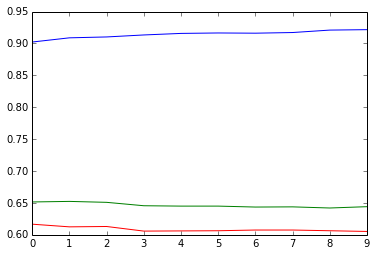

In [69]:
iters = range(len(model.Ws))
plt.plot(iters, gen_f1s)
plt.plot(iters, train_f1s)
plt.plot(iters, dev_f1s)

## TF-IDF baseline

In [49]:
from scipy import sparse
I = sparse.identity(X_train.shape[1], format='csr')

In [66]:
get_set_scores(model, X_train, predicted, N_pos_train_pred, W=I, b=0.0)

P:	0.890003459011
R:	0.894645340751
F1:	0.8923183631


(0.890003459010723, 0.8946453407510431, 0.8923183631003989)

In [50]:
get_set_scores(model, X_train, train_pos_labels, N_pos_train, W=I, b=0.0)

P:	0.75717744725
R:	0.565633074935
F1:	0.647537346546


(0.7571774472500865, 0.5656330749354005, 0.647537346546369)

In [60]:
get_set_scores(model, X_dev, dev_pos_labels, N_pos_dev, W=I, b=0.0)

P:	0.690721649485
R:	0.556086519115
F1:	0.616134875296


(0.6907216494845361, 0.5560865191146881, 0.6161348752960847)

## Debugging...

In [57]:
X_dev.shape

(3976, 271513)

In [56]:
i = 2
print X_dev.getrow(i)
print model.predict(X_dev.getrow(i))
print dev_pos_labels[i]

  (0, 8191)	1.0
set([2040])
2040.0


### Functions...

In [34]:
def get_set_scores(model, X, X_labels, N_pos, W=None, b=None, display=True):
    predicted = 0
    correct   = 0
    for i in range(X.shape[0]):
        yp = model.predict(X.getrow(i), W=W, b=b)
        if yp is not None:
            predicted += 1
        
            # NOTE: we assume we're doing disambiguation perfectly here!!!
            if X_labels[i] in yp:
                correct += 1

    prec   = correct / float(predicted)
    recall = correct / float(N_pos)
    f1     = (2 * prec * recall) / (prec +  recall)
    if display:
        print "P:\t", prec
        print "R:\t", recall
        print "F1:\t", f1
    return prec, recall, f1